# Intro
I am solving a regression problem using pyspark. The ultimate goal is to create a linear regression for this dataset. Here I begin to explore the data with the plan of elimating unwanted features. However, when I realize that there are over 130 different features with the one hot encoded categorical features further expanding the number of columns, I switch to determining the top 20 features to include in a linear model.

First I'm going to set up the data.

In [1]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from statsmodels.stats import weightstats as stests
import findspark
findspark.init()
import pyspark
from pyspark.ml.tuning import TrainValidationSplit
import statsmodels as st

In [412]:
# use this to change row settings
pd.set_option("display.max_rows", None)
# pd.set_option('display.max_rows', 100)

In [2]:
# initializing or closing SparkContext
sc = pyspark.SparkContext()
# sc.stop()

In [16]:
# importing the initial csv as an rdd
data = sc.textFile('credit_card_regression_set.csv')
data = data.map(lambda col: col.split(','))

In [29]:
# initializing a SparkSession
spark = pyspark.sql.SparkSession(sc)

In [2]:
# Made a dictionary object using provided data dictionary to find column descriptions
Dictionary_dataframe = pd.read_csv('Credit_Card_Data Dictionary.csv')
columns = list(Dictionary_dataframe.iloc[:,0])
descriptions = list(Dictionary_dataframe.iloc[:,1])
zipped = zip(columns, descriptions)
description_dictionary = {column : description for column, description in zipped}
len(description_dictionary)

133

In [9]:
description_dictionary['empcat']

'Years with current employer'

In [597]:
# Entering the data as a spark dataframe and creating a temp view so that I can use sql queries if needed.
dataframe = spark.read.option('header', True).option('inferSchema', True).csv('credit_card_regression_set.csv')
dataframe.createOrReplaceTempView('credit')

# Feature Exploration
There are 133 features in this dataset. I need to determine which ones are useful along with properly preparing them for a regression model. I'm going to start by going through the list and determining columns that give no real information. As a start, the custid column won't provide real information because it is a randomly assigned id number. It won't be helpful in calculating any relationships. I'll first eliminate columns by reading through the list and using my description_dictionary to learn more where necessary. I'll add these columns to a drop columns list along with logic for dropping said columns.

In [70]:
# This is the dependent variable that I'm aiming to predict.
target_variable = 'creddebt'

In [ ]:
dataframe.printSchema()

'birthmonth' doesn't indicate any useful information

'ed' and 'edcat' a education descriptions. Using the description dictionary, an sql query, and the original dictionary I find that these numerical variables are mapped to different degrees. Both categories aren't needed, but 'edcat' would be more useful because it categorically defines education. Someone for instance could go through 6 years of school after highschool to get their college degree while another person takes 6 years after highschool to get a post undergraduate degree. Therefore the education category would better exemplify these distinctions.

In [76]:
spark.sql('SELECT DISTINCT edcat FROM credit').show()

+-----+
|edcat|
+-----+
|  1.0|
|  4.0|
|  3.0|
|  2.0|
|  5.0|
+-----+



In [83]:
spark.sql('SELECT employ, empcat FROM credit').show()

+------+------+
|employ|empcat|
+------+------+
|   0.0|   1.0|
|   0.0|   1.0|
|  16.0|   5.0|
|   0.0|   1.0|
|   1.0|   1.0|
|  22.0|   5.0|
|  10.0|   3.0|
|  11.0|   4.0|
|  15.0|   4.0|
|  19.0|   5.0|
|   8.0|   3.0|
|   4.0|   2.0|
|  12.0|   4.0|
|   3.0|   2.0|
|  27.0|   5.0|
|  31.0|   5.0|
|  24.0|   5.0|
|  29.0|   5.0|
|   4.0|   2.0|
|  10.0|   3.0|
+------+------+
only showing top 20 rows



'employ' makes more sense to keep than 'empcat'. 'empcat only features information loss.

In [87]:
spark.sql('SELECT DISTINCT hometype FROM credit').show()

+--------+
|hometype|
+--------+
|     1.0|
|     4.0|
|     3.0|
|     2.0|
+--------+



spoused behaved simlarly to the 'ed' category.

The presence of several pet categories seemed redundant. I will only keep the total number of pets.

'addresscat' didn't provide as much information as 'address'.

'cartype' and 'carcarvalue' were also redundant.


In [88]:
description_dictionary['addresscat']

'Years at current address'

# Assigning features
I need to distinguish between the numeric and categorical features and appropriately assign them. The data dictionary dataset has a column that can be used for this.

In [450]:
binary = []
categorical = []
numerical = []
for variable in list(dataframe.columns):
    num_categories = dataframe.select(variable).distinct().count()
    if num_categories == 2:
        binary.append(variable)
    elif (num_categories > 2) & (num_categories <= 29):
        categorical.append(variable)
    else:
        numerical.append(variable)
    print('Num categories for '+ str(variable) + ' is ' + str(num_categories))
        

Num categories for custid is 5000
Num categories for region is 5
Num categories for townsize is 6
Num categories for gender is 2
Num categories for age is 62
Num categories for agecat is 5
Num categories for birthmonth is 12
Num categories for ed is 18
Num categories for edcat is 5
Num categories for jobcat is 6
Num categories for union is 2
Num categories for employ is 52
Num categories for empcat is 5
Num categories for retire is 2
Num categories for income is 266
Num categories for lninc is 218
Num categories for inccat is 5
Num categories for debtinc is 325
Num categories for creddebt is 775
Num categories for lncreddebt is 654
Num categories for othdebt is 1146
Num categories for lnothdebt is 595
Num categories for default is 2
Num categories for jobsat is 5
Num categories for marital is 2
Num categories for spoused is 22
Num categories for spousedcat is 6
Num categories for reside is 9
Num categories for pets is 20
Num categories for pets_cats is 7
Num categories for pets_dogs is

In [329]:
all_pd = dataframe.toPandas()
numeric_pd = dataframe.select(numerical).toPandas()
binary_pd = dataframe.select(binary).toPandas()
categorical_pd = dataframe.select(categorical).toPandas()

In [451]:
len(dataframe.columns)

130

In [452]:
print('Numeric: ' ,len(numerical),'  Binary ', len(binary),'  Categorical ', len(categorical),'  Total: ', len(numerical) + len(binary) + len(categorical))

Numeric:  39   Binary  49   Categorical  42   Total:  130


# Numeric Columns

In [478]:
numeric_drop = [
 'custid','lninc',
 'lncreddebt',
 'lnothdebt',
 'lnlongmon',
 'lnlongten',
 'lntollmon',
 'lntollten',
 'lnequipmon',
 'lnequipten',
 'lncardmon',
 'lncardten',
 'lnwiremon',
 'lnwireten',]

In [477]:
list(numeric_pd.columns)

['age',
 'employ',
 'income',
 'lninc',
 'debtinc',
 'creddebt',
 'lncreddebt',
 'othdebt',
 'lnothdebt',
 'address',
 'carvalue',
 'commutetime',
 'cardtenure',
 'card2tenure',
 'cardspent',
 'card2spent',
 'tenure',
 'longmon',
 'lnlongmon',
 'longten',
 'lnlongten',
 'tollmon',
 'lntollmon',
 'tollten',
 'lntollten',
 'equipmon',
 'lnequipmon',
 'equipten',
 'lnequipten',
 'cardmon',
 'lncardmon',
 'cardten',
 'lncardten',
 'wiremon',
 'lnwiremon',
 'wireten',
 'lnwireten',
 'hourstv']

In [479]:
numeric_pd = numeric_pd.drop(numeric_drop, axis = 1)

In [456]:
numeric_pd.head(5)

,age,employ,income,lninc,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,address,...,lnequipten,cardmon,lncardmon,cardten,lncardten,wiremon,lnwiremon,wireten,lnwireten,hourstv
0,20.0,0.0,31.0,3.43,11.1,1.20,0.18,2.24,0.81,0.0,...,4.84,14.25,2.66,60.00,4.09,0.00,#NULL!,0.00,#NULL!,13.0
1,22.0,0.0,15.0,2.71,18.6,1.22,0.20,1.57,0.45,2.0,...,7.59,16.00,2.77,610.00,6.41,45.65,3.82,1683.55,7.43,18.0
2,67.0,16.0,35.0,3.56,9.9,0.93,-0.07,2.54,0.93,30.0,...,#NULL!,23.00,3.14,1410.00,7.25,0.00,#NULL!,0.00,#NULL!,21.0
3,23.0,0.0,20.0,3.00,5.7,0.02,-3.78,1.12,0.11,3.0,...,#NULL!,21.00,3.04,685.00,6.53,0.00,#NULL!,0.00,#NULL!,26.0
4,26.0,1.0,23.0,3.14,1.7,0.21,-1.54,0.18,-1.74,3.0,...,#NULL!,17.25,2.85,360.00,5.89,19.05,2.95,410.80,6.02,27.0


In [ ]:
pd.to_numeric(numeric_pd['lncreddebt'], errors = 'coerce')

In [215]:
number = numeric_pd['income'].corr(numeric_pd['creddebt'])

In [445]:
numerical = numerical.remove('custid')

In [514]:
# Used this code to discover that 0 values were invalidating some of my graphs.
x.apply(lambda o: np.log(o) ==  0).value_counts()

False    4988
True       12
Name: creddebt, dtype: int64

Some of the vairables include log counter parts so in order to measure their effectiveness I deccided to graph the distribution changes along with using a series of statistical tests and descriptive features to determine the feature importance. Shapirowilk tests for distribution normality. Pearsonr test for significance linear correlation while spearmanr tests for significance of monotonic correlation. Correlation is the linear correlation between the two variables.

age
Correlation between age and creddebt is 0.11961855123488274)


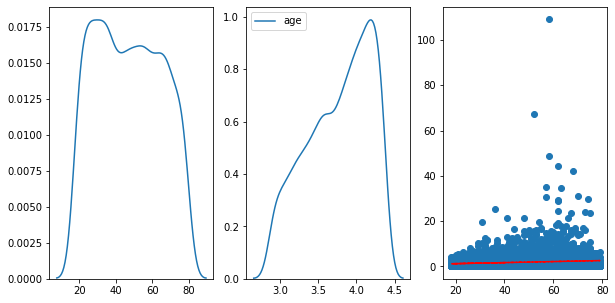

employ
Correlation between employ and creddebt is 0.19312008287332005)


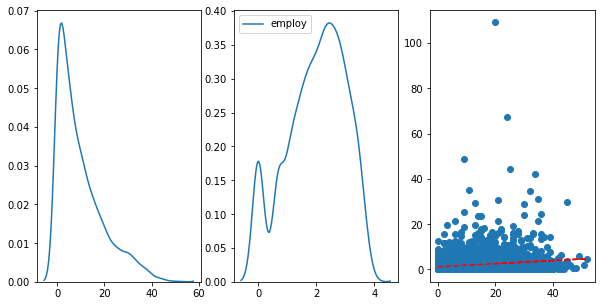

income
Correlation between income and creddebt is 0.6674504579827917)


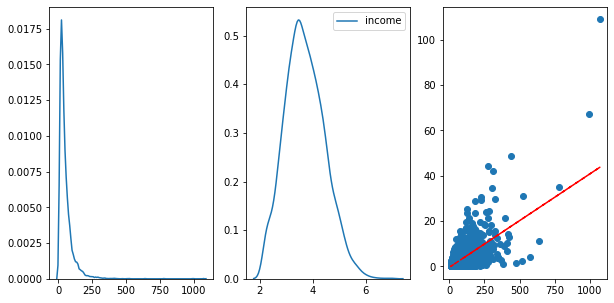

debtinc
Correlation between debtinc and creddebt is 0.368392862450463)


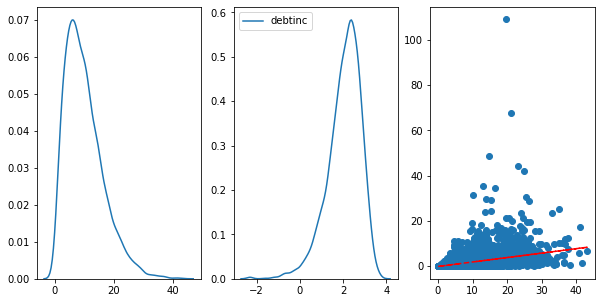

creddebt
Correlation between creddebt and creddebt is 1.0)


C:\Users\Allen\anaconda3\lib\site-packages\seaborn\distributions.py:690: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
C:\Users\Allen\anaconda3\lib\site-packages\matplotlib\contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\Allen\anaconda3\lib\site-packages\matplotlib\contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\Allen\anaconda3\lib\site-packages\seaborn\distributions.py:434: UserWarning: No contour levels were found within the data range.
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


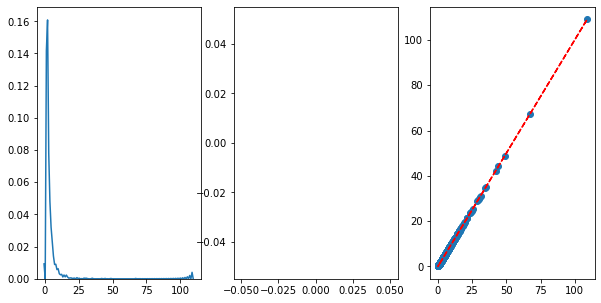

othdebt
Correlation between othdebt and creddebt is 0.6673415903778087)


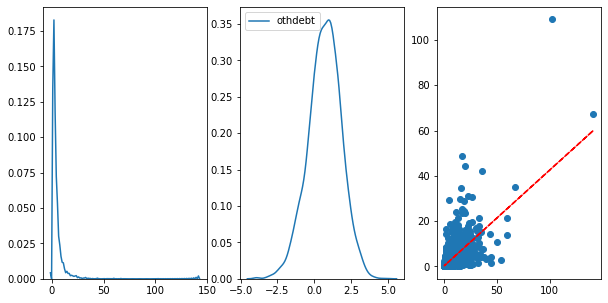

address
Correlation between address and creddebt is 0.14380302795429528)


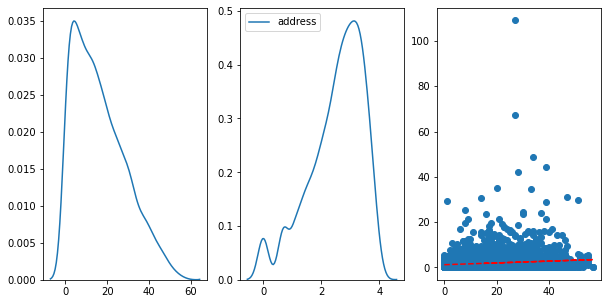

carvalue
Correlation between carvalue and creddebt is 0.4422447029179825)


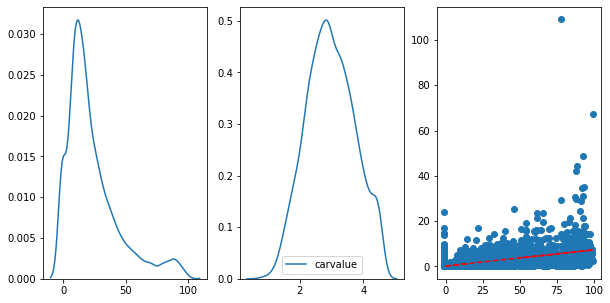

commutetime
Correlation between commutetime and creddebt is -0.003064482396063465)


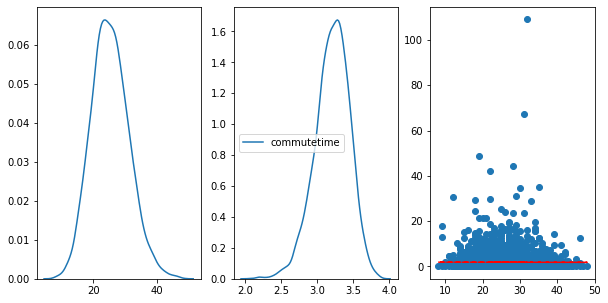

cardtenure
Correlation between cardtenure and creddebt is 0.14698465944890166)


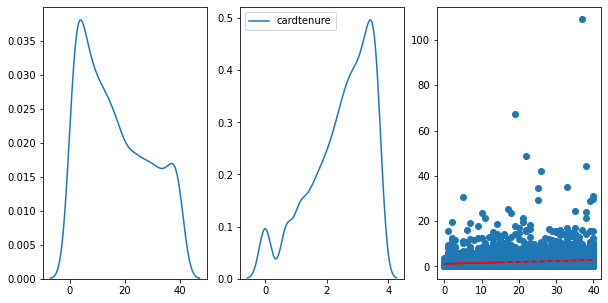

card2tenure
Correlation between card2tenure and creddebt is 0.1467828249448459)


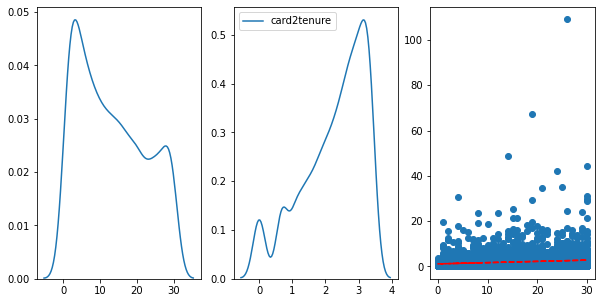

cardspent
Correlation between cardspent and creddebt is 0.24976637221033315)


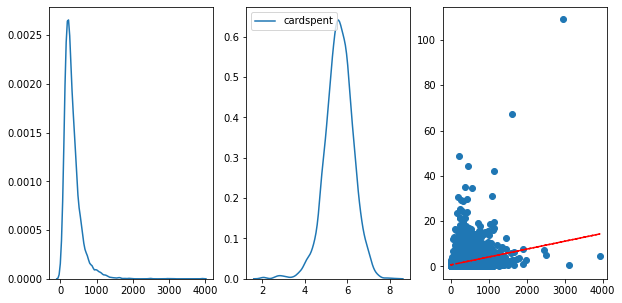

card2spent
Correlation between card2spent and creddebt is 0.21851242919222816)


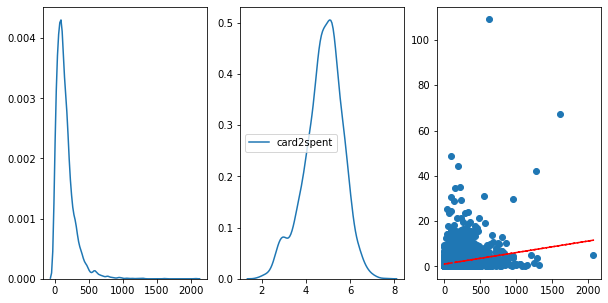

tenure
Correlation between tenure and creddebt is 0.1296809005612616)


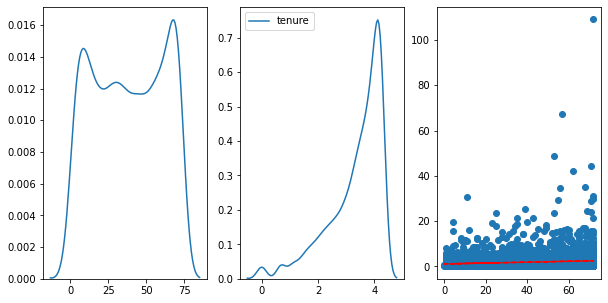

longmon
Correlation between longmon and creddebt is 0.11033932980899981)


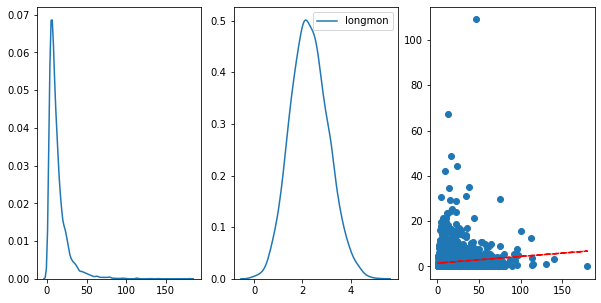

longten
Correlation between longten and creddebt is 0.11462765404384857)


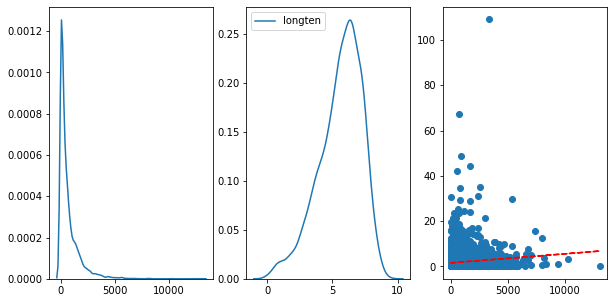

tollmon
Correlation between tollmon and creddebt is 0.14078800518257772)


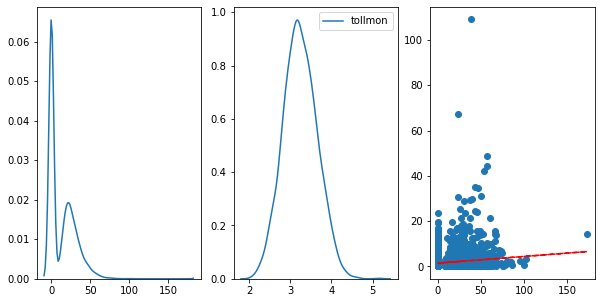

tollten
Correlation between tollten and creddebt is 0.16998991376014852)


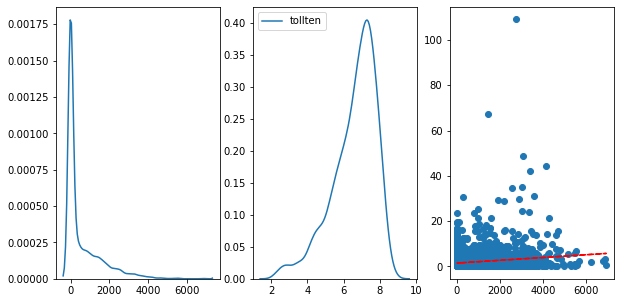

equipmon
Correlation between equipmon and creddebt is 0.04166538512687846)


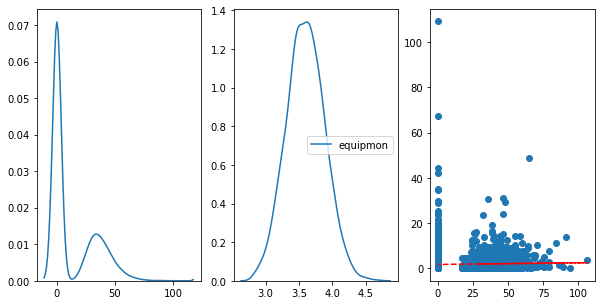

equipten
Correlation between equipten and creddebt is 0.07800354091128446)


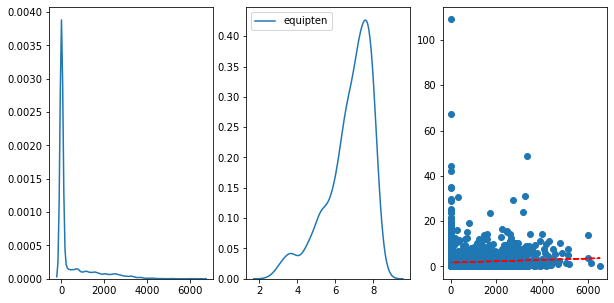

cardmon
Correlation between cardmon and creddebt is 0.08496069444084701)


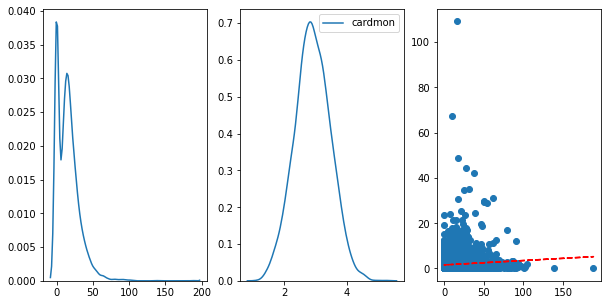

cardten
Correlation between cardten and creddebt is 0.0984318750622866)


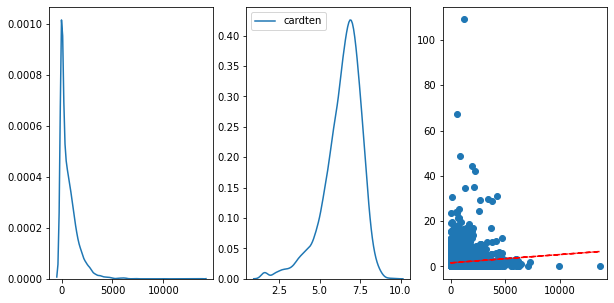

wiremon
Correlation between wiremon and creddebt is 0.11557826730459499)


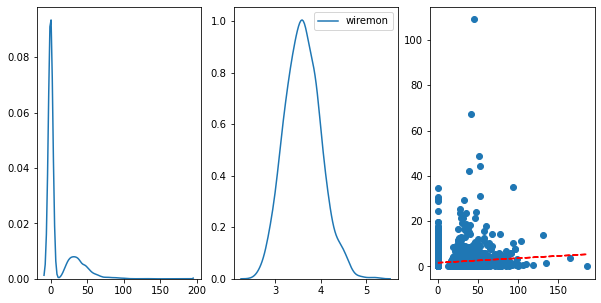

wireten
Correlation between wireten and creddebt is 0.14844560434243997)


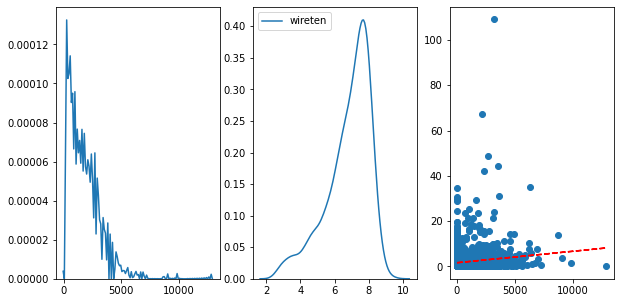

hourstv
Correlation between hourstv and creddebt is 0.03757226973447818)


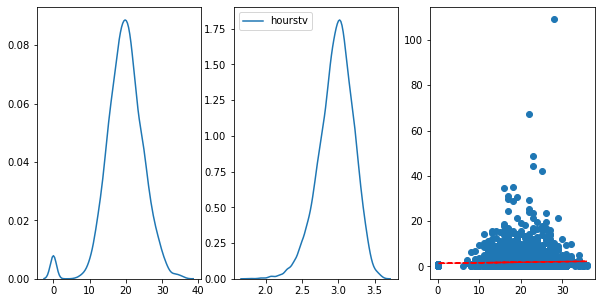

In [547]:
column_names_list = []
shapirowilk = []
spearmanr = []
pearsonr = []
corr = []

for column in list(numeric_pd.columns):
    print(column)
    x = pd.to_numeric(numeric_pd[column], errors = 'coerce')
    x = x.fillna(x.mean())
    y = numeric_pd['creddebt']
    
    dataframe = pd.concat([x,y], axis = 1)
    logframe = dataframe[dataframe[column] != 0]
    lx = logframe[column].apply(lambda o: np.log(o))
    ly = logframe['creddebt']
    
    shapiro_val = scipy.stats.shapiro(x).pvalue
    pearson_val = scipy.stats.pearsonr(x, y)[1]
    spearman_val = scipy.stats.spearmanr(x,y)[1]
    correlation = x.corr(y)
    print('Correlation between {} and creddebt is {})'.format(column, correlation))
    
    fig, axs = plt.subplots(1,3, figsize = (10,5))
    
    
    sns.kdeplot(np.array(x), ax = axs[0])
    sns.kdeplot(lx, ax = axs[1])
    axs[2].scatter(x, y)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    axs[2].plot(x,p(x),"r--")
    

    plt.show()
    
    
    column_names_list.append(column)
    shapirowilk.append(shapiro_val)
    spearmanr.append(spearman_val)
    pearsonr.append(pearson_val)
    corr.append(correlation)
numeric_column_info = {'column' : column_names_list , 'shapirowilk' : shapirowilk, 'spearmanr' : spearmanr, 'pearsonr': pearsonr, 'correlation' : corr}
numeric_info_pd = pd.DataFrame(numeric_column_info)


Best numeric variables based on correlation:

In [591]:
best_nums = list(numeric_info_pd.sort_values('correlation', ascending = False).head(11).column)

In [592]:
best_nums

['creddebt',
 'income',
 'othdebt',
 'carvalue',
 'debtinc',
 'cardspent',
 'card2spent',
 'employ',
 'tollten',
 'wireten',
 'cardtenure']

# Categorical 

In [326]:
categorical_pd = categorical_pd.astype('object')

In [371]:
categorical_pd = pd.get_dummies(categorical_pd)

In [389]:
all_cat = pd.concat([categorical_pd, all_pd['creddebt']], axis = 1)
all_cat = pd.concat([all_cat, binary_pd], axis = 1)

In [390]:
all_cat['creddebt']

0       1.20
1       1.22
2       0.93
3       0.02
4       0.21
        ... 
4995    7.93
4996    3.34
4997    3.56
4998    5.02
4999    2.27
Name: creddebt, Length: 5000, dtype: float64

Here I was checking that column lengths add up. The + 1 was added for the predictor variable.

In [391]:
len(categorical_pd.columns) + 1 + len(binary_pd.columns)

342

In [393]:
len(all_cat.columns)

342

This code iterates through the categorical variables and runs a z test. It lists the column name, p values, and total population for each group to determine the balance between the populations. 

In [ ]:
column_names_list = []
p_value_list = []
set0_list = []
set1_list = []


for column in all_cat.drop('creddebt', axis = 1).columns:
    x0 = all_cat[['creddebt']][all_cat[column] == 0]
    x1 = all_cat[['creddebt']][all_cat[column] != 0]
    
    x0len = len(x0)
    x1len = len(x1)


#     print('length set 0 =', len(x0))
#     print('length set 1 =', len(x1))


    # fig, axs = plt.subplots(1,2)

    # sns.kdeplot(np.array(x0['creddebt']))
    # sns.kdeplot(np.array(x1['creddebt']))

    # plt.xlim(0,20)

    t, p = st.stats.weightstats.ztest(x0, x1)

    column_names_list.append(column)
    p_value_list.append(p)
    set0_list.append(x0len)
    set1_list.append(x1len)
    
cat_info = {'column' : column_names_list , 'p_value' : p_value_list, 'set1_pop' : set0_list, 'set2_pop': set1_list}
cat_info_pd =  pd.DataFrame(cat_info)

I clean p value column so that it can be sorted as a numerical variable then I filter all the variables that were statistically significant as 'cat95'. I also take the root because there are potentially repetitions of the same value. (For instance I don't want to count 'incat_1' and 'incat_2' as separate variables I simply want 'incat')

In [408]:
cat_info_pd['p_value'] = cat_info_pd['p_value'].astype('string').str.replace('[','').str.replace(']', '').astype('float')

cat95 = cat_info_pd[cat_info_pd['p_value'] < .05]

cat95['root'] = cat95.column.apply(lambda word: word.split('_')[0])

C:\Users\Allen\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [440]:
significant_categories = list(set(cat95.root))

['bfast',
 'addresscat',
 'news',
 'pets',
 'confer',
 'jobsat',
 'spoused',
 'vote',
 'retire',
 'edcat',
 'carbought',
 'ownvcr',
 'ownfax',
 'forward',
 'ownpda',
 'agecat',
 'commutecat',
 'jobcat',
 'default',
 'carown',
 'spousedcat',
 'ed',
 'card',
 'active',
 'voice',
 'callid',
 'owncd',
 'owndvd',
 'commutecar',
 'callwait',
 'cardtenurecat',
 'owntv',
 'empcat',
 'reside',
 'polview',
 'pager',
 'churn',
 'inccat',
 'hometype',
 'tollfree',
 'multline',
 'homeown',
 'commute',
 'internet',
 'cars',
 'wireless',
 'card2',
 'card2tenurecat',
 'callcard',
 'carcatvalue']

In [593]:
best_cats = list(cat95.sort_values(by = 'p_value').drop_duplicates( subset = 'root').head(10).root)

best_cats

['inccat',
 'carcatvalue',
 'default',
 'empcat',
 'agecat',
 'cardtenurecat',
 'card2tenurecat',
 'retire',
 'carown',
 'jobsat']

In [561]:
cat_info_pd.sort_values(by = 'p_value')

,column,p_value,set1_pop,set2_pop
66,inccat_5.0,9.544564e-250,4616,384
217,carcatvalue_3.0,9.771874e-186,4163,837
215,carcatvalue_1.0,1.170855e-98,2601,2399
62,inccat_1.0,7.958056e-63,3670,1330
295,default,6.793861e-57,3829,1171
61,empcat_5.0,1.276411e-31,3865,1135
14,agecat_5.0,8.879675e-31,3805,1195
63,inccat_2.0,9.251476e-25,3203,1797
65,inccat_4.0,1.750713e-23,4350,650
265,cardtenurecat_5.0,7.078232e-22,2649,2351


In [594]:
best_20 = []
best_20.extend(best_cats)
best_20.extend(best_nums)

Based on my observations I chose 20 features that I think will be useful for the regression. The next steps are to prepare the features and begin modeling the data.

In [596]:
print(best_20)

['inccat', 'carcatvalue', 'default', 'empcat', 'agecat', 'cardtenurecat', 'card2tenurecat', 'retire', 'carown', 'jobsat', 'creddebt', 'income', 'othdebt', 'carvalue', 'debtinc', 'cardspent', 'card2spent', 'employ', 'tollten', 'wireten', 'cardtenure']


In [90]:
# columns I decided I was going to drop but didn't continue with this approach
columns_to_drop = ['custid', 'birthmonth', 'ed', 'employ', 'spoused',
                   'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles',
                   'pets_small','pets_saltfish','pets_freshfish', 'addresscat','cartype','carcatvalue',
                  ]